In [1]:
import numpy as np
import os
# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling, BatchNormalization

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline


print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/train"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
batch_size = 128
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

print(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Méthode d'analyse des résultats
def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2025-03-24 17:43:47.214522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742834627.243808  118350 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742834627.251450  118350 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742834627.275607  118350 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742834627.275626  118350 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742834627.275627  118350 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905', '40', '50', '60']
Found 54000 files belonging to 27 classes.
Using 43200 files for training.


I0000 00:00:1742834661.059618  118350 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


## Définition des couches partagées

In [2]:
def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()






## modèle MobileNetV2

Phase 1: Entraînement des couches supérieures
Epoch 1/10


I0000 00:00:1742834734.533998  118599 cuda_dnn.cc:529] Loaded cuDNN version 90800


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0529 - loss: 3.4864 

2025-03-24 17:46:33.516993: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 79s 200ms/step - accuracy: 0.0529 - loss: 3.4859 - val_accuracy: 0.1970 - val_loss: 3.0362 - learning_rate: 1.0000e-04
Epoch 2/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:21 241ms/step - accuracy: 0.1172 - loss: 3.0860

2025-03-24 17:46:45.983450: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1303 - loss: 3.0513 

2025-03-24 17:47:40.204804: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 67s 197ms/step - accuracy: 0.1304 - loss: 3.0511 - val_accuracy: 0.2908 - val_loss: 2.6172 - learning_rate: 1.0000e-04
Epoch 3/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:19 235ms/step - accuracy: 0.2109 - loss: 2.7589

2025-03-24 17:47:52.573201: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.1977 - loss: 2.7854 

2025-03-24 17:48:46.515208: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.1977 - loss: 2.7852 - val_accuracy: 0.3293 - val_loss: 2.4114 - learning_rate: 1.0000e-04
Epoch 4/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:22 244ms/step - accuracy: 0.1797 - loss: 2.7110

2025-03-24 17:48:58.893380: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2323 - loss: 2.6409 

2025-03-24 17:49:52.929671: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.2324 - loss: 2.6409 - val_accuracy: 0.3500 - val_loss: 2.2964 - learning_rate: 1.0000e-04
Epoch 5/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:19 236ms/step - accuracy: 0.2188 - loss: 2.5606

2025-03-24 17:50:05.292244: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2571 - loss: 2.5463 

2025-03-24 17:50:59.327026: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.2571 - loss: 2.5462 - val_accuracy: 0.3630 - val_loss: 2.2208 - learning_rate: 1.0000e-04
Epoch 6/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:18 232ms/step - accuracy: 0.3281 - loss: 2.3892

2025-03-24 17:51:11.680119: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2791 - loss: 2.4794 

2025-03-24 17:52:05.645495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.2791 - loss: 2.4794 - val_accuracy: 0.3776 - val_loss: 2.1683 - learning_rate: 1.0000e-04
Epoch 7/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:21 240ms/step - accuracy: 0.2812 - loss: 2.4623

2025-03-24 17:52:18.014253: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2948 - loss: 2.4220 

2025-03-24 17:53:12.071536: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.2948 - loss: 2.4220 - val_accuracy: 0.3845 - val_loss: 2.1330 - learning_rate: 1.0000e-04
Epoch 8/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:18 233ms/step - accuracy: 0.2969 - loss: 2.3749

2025-03-24 17:53:24.432750: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3049 - loss: 2.3927 

2025-03-24 17:54:18.481660: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.3049 - loss: 2.3927 - val_accuracy: 0.3892 - val_loss: 2.0927 - learning_rate: 1.0000e-04
Epoch 9/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:17 231ms/step - accuracy: 0.3516 - loss: 2.3076

2025-03-24 17:54:30.834567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3139 - loss: 2.3486 

2025-03-24 17:55:24.840982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.3139 - loss: 2.3486 - val_accuracy: 0.4010 - val_loss: 2.0623 - learning_rate: 1.0000e-04
Epoch 10/10
  1/338 ━━━━━━━━━━━━━━━━━━━━ 1:20 239ms/step - accuracy: 0.2734 - loss: 2.2673

2025-03-24 17:55:37.206523: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3158 - loss: 2.3281 

2025-03-24 17:56:31.252307: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.3158 - loss: 2.3281 - val_accuracy: 0.4051 - val_loss: 2.0455 - learning_rate: 1.0000e-04
Phase 2: Fine-tuning du modèle
Epoch 11/30


2025-03-24 17:56:54.017643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3009 - loss: 2.4019  

2025-03-24 17:58:26.034695: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 115s 299ms/step - accuracy: 0.3010 - loss: 2.4017 - val_accuracy: 0.3956 - val_loss: 2.0461 - learning_rate: 5.0000e-05
Epoch 12/30


2025-03-24 17:58:38.413506: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3707 - loss: 2.1525  

2025-03-24 18:00:04.537287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 98s 291ms/step - accuracy: 0.3707 - loss: 2.1524 - val_accuracy: 0.4143 - val_loss: 2.0166 - learning_rate: 5.0000e-05
Epoch 13/30


2025-03-24 18:00:16.917715: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.3988 - loss: 2.0444  

2025-03-24 18:01:43.636590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 293ms/step - accuracy: 0.3988 - loss: 2.0444 - val_accuracy: 0.4346 - val_loss: 1.9082 - learning_rate: 5.0000e-05
Epoch 14/30


2025-03-24 18:01:56.094892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4203 - loss: 1.9612  

2025-03-24 18:03:22.366976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.4203 - loss: 1.9611 - val_accuracy: 0.4571 - val_loss: 1.8232 - learning_rate: 5.0000e-05
Epoch 15/30


2025-03-24 18:03:34.778530: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4408 - loss: 1.9010  

2025-03-24 18:05:01.085522: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.4408 - loss: 1.9009 - val_accuracy: 0.4793 - val_loss: 1.7456 - learning_rate: 5.0000e-05
Epoch 16/30


2025-03-24 18:05:13.499213: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4549 - loss: 1.8439  

2025-03-24 18:06:39.746798: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.4549 - loss: 1.8438 - val_accuracy: 0.4796 - val_loss: 1.7472 - learning_rate: 5.0000e-05
Epoch 17/30


2025-03-24 18:06:52.157589: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4674 - loss: 1.7948  

2025-03-24 18:08:18.471292: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.4674 - loss: 1.7948 - val_accuracy: 0.4915 - val_loss: 1.6983 - learning_rate: 5.0000e-05
Epoch 18/30


2025-03-24 18:08:30.857201: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4830 - loss: 1.7462  

2025-03-24 18:09:57.272171: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.4831 - loss: 1.7462 - val_accuracy: 0.5080 - val_loss: 1.6576 - learning_rate: 5.0000e-05
Epoch 19/30


2025-03-24 18:10:09.621813: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4960 - loss: 1.7041  

2025-03-24 18:11:35.791895: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 291ms/step - accuracy: 0.4960 - loss: 1.7040 - val_accuracy: 0.5094 - val_loss: 1.6581 - learning_rate: 5.0000e-05
Epoch 20/30


2025-03-24 18:11:48.163435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5040 - loss: 1.6588  

2025-03-24 18:13:14.389590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.5040 - loss: 1.6588 - val_accuracy: 0.5155 - val_loss: 1.6221 - learning_rate: 5.0000e-05
Epoch 21/30


2025-03-24 18:13:26.754955: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5216 - loss: 1.6135  

2025-03-24 18:14:52.995146: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.5216 - loss: 1.6134 - val_accuracy: 0.5244 - val_loss: 1.5917 - learning_rate: 5.0000e-05
Epoch 22/30


2025-03-24 18:15:05.375836: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5295 - loss: 1.5806  

2025-03-24 18:16:31.564494: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.5295 - loss: 1.5805 - val_accuracy: 0.5388 - val_loss: 1.5513 - learning_rate: 5.0000e-05
Epoch 23/30


2025-03-24 18:16:43.947550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5374 - loss: 1.5459  

2025-03-24 18:18:10.228760: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.5374 - loss: 1.5459 - val_accuracy: 0.5367 - val_loss: 1.5528 - learning_rate: 5.0000e-05
Epoch 24/30


2025-03-24 18:18:22.596486: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5490 - loss: 1.5056  

2025-03-24 18:19:48.731873: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 291ms/step - accuracy: 0.5490 - loss: 1.5056 - val_accuracy: 0.5434 - val_loss: 1.5523 - learning_rate: 5.0000e-05
Epoch 25/30


2025-03-24 18:20:01.100618: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5571 - loss: 1.4705  

2025-03-24 18:21:27.178385: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 98s 291ms/step - accuracy: 0.5571 - loss: 1.4705 - val_accuracy: 0.5505 - val_loss: 1.5193 - learning_rate: 5.0000e-05
Epoch 26/30


2025-03-24 18:21:39.548755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5673 - loss: 1.4410  

2025-03-24 18:23:05.727570: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 291ms/step - accuracy: 0.5673 - loss: 1.4410 - val_accuracy: 0.5472 - val_loss: 1.5378 - learning_rate: 5.0000e-05
Epoch 27/30


2025-03-24 18:23:18.111328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5761 - loss: 1.4118  

2025-03-24 18:24:44.167292: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 98s 291ms/step - accuracy: 0.5762 - loss: 1.4118 - val_accuracy: 0.5350 - val_loss: 1.5894 - learning_rate: 5.0000e-05
Epoch 28/30


2025-03-24 18:24:56.544680: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5872 - loss: 1.3812  

2025-03-24 18:26:22.843402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.5872 - loss: 1.3811 - val_accuracy: 0.5424 - val_loss: 1.5587 - learning_rate: 5.0000e-05
Epoch 29/30


2025-03-24 18:26:35.210441: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5959 - loss: 1.3443  

2025-03-24 18:28:01.319896: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 98s 291ms/step - accuracy: 0.5959 - loss: 1.3443 - val_accuracy: 0.5581 - val_loss: 1.4975 - learning_rate: 2.5000e-05
Epoch 30/30


2025-03-24 18:28:13.701954: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6040 - loss: 1.3290  

2025-03-24 18:29:39.942725: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


338/338 ━━━━━━━━━━━━━━━━━━━━ 99s 292ms/step - accuracy: 0.6040 - loss: 1.3290 - val_accuracy: 0.5602 - val_loss: 1.4965 - learning_rate: 2.5000e-05
 1/85 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.5859 - loss: 1.4815

2025-03-24 18:29:52.314196: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5610 - loss: 1.5020
Précision de validation finale: 0.5602


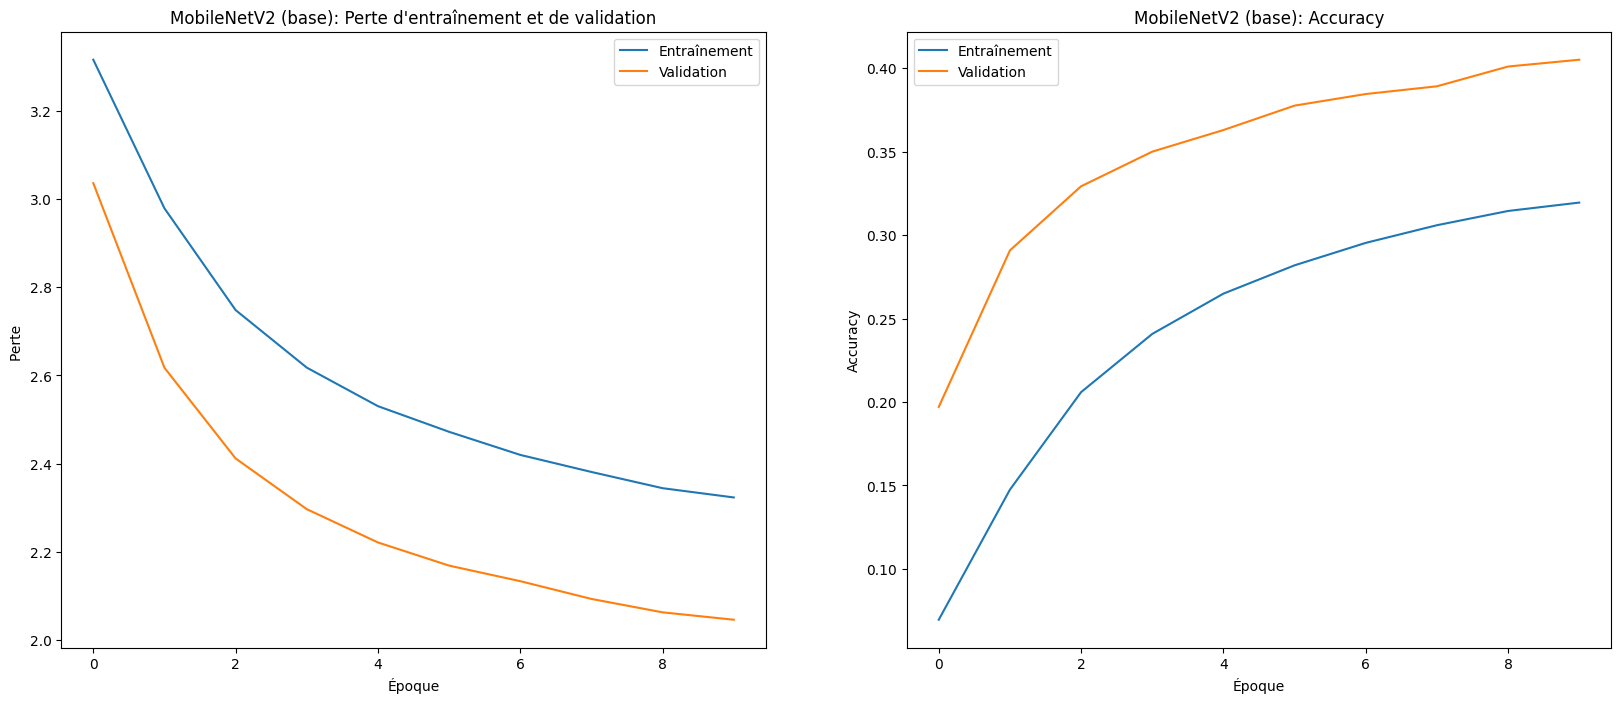

 1/85 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 0.5938 - loss: 1.4127

2025-03-24 18:30:05.186823: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5580 - loss: 1.5088
Précision de validation finale: 0.5602


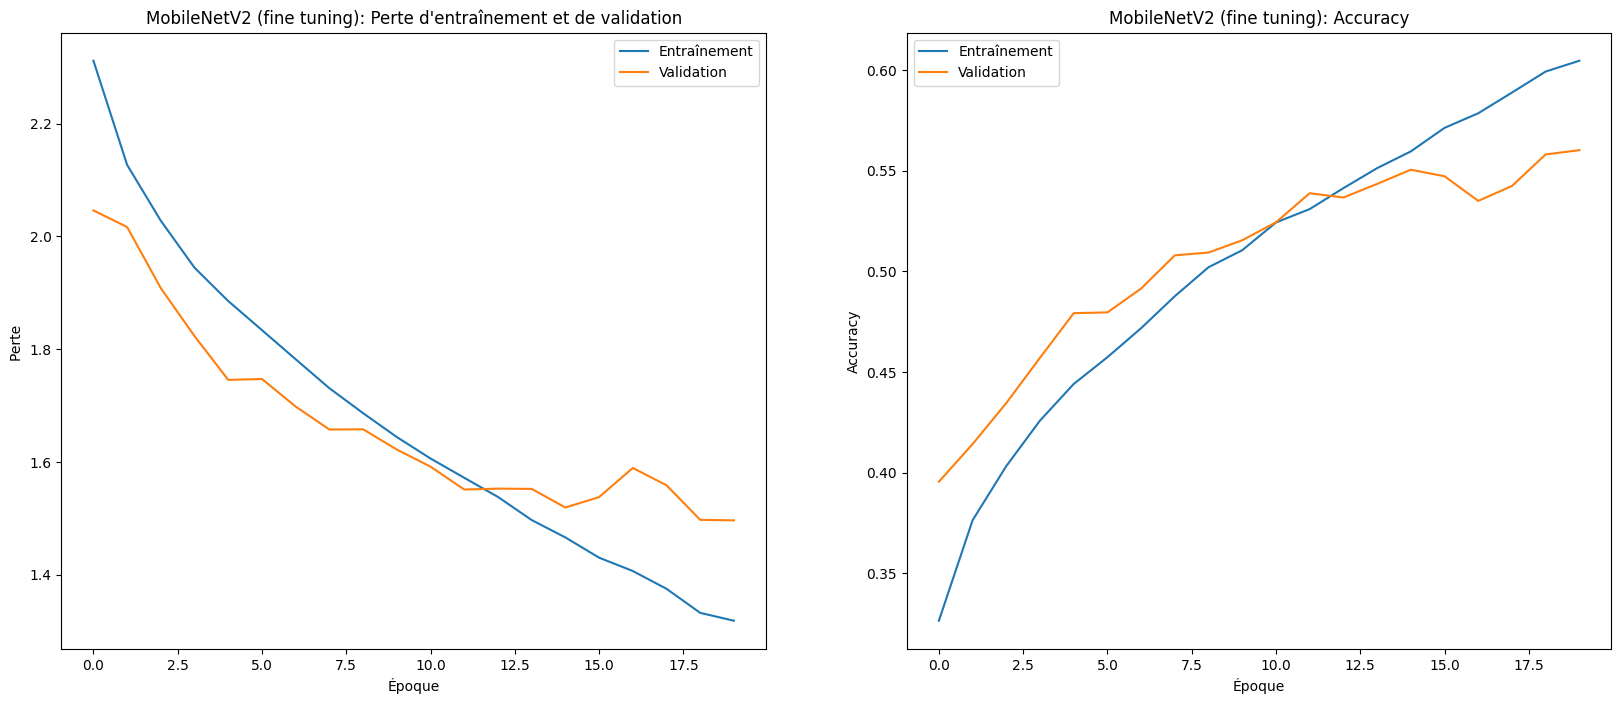

2025-03-24 18:30:17.961721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134218240 bytes after encountering the first element of size 134218240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-03-24 18:30:18.047512: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-03-24 18:30:18.047576: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-03-24 18:30:18.047619: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-03-24 18:30:18.047661: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025-03-24 18:30:19.185371: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━

2025-03-24 18:30:38.753450: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


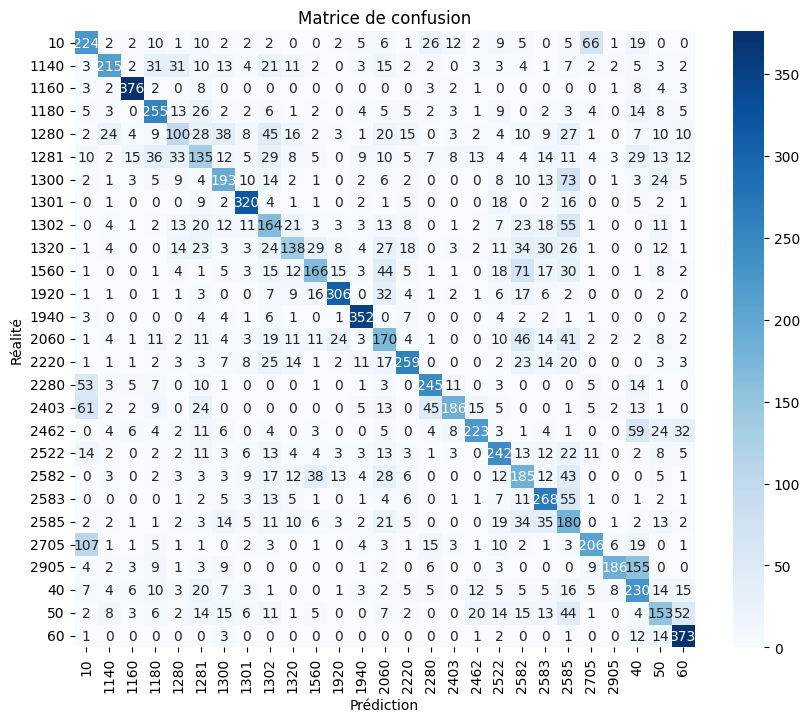

In [3]:
### ARCHITECTURE DU MODEL ###

import tensorflow as tf 
from tensorflow.keras.applications import MobileNetV2

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# 1. Choisir un modèle préentraîné
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Geler d'abord le modèle de base

# 2. Construire le modèle complet
model = tf.keras.Sequential([
    # Augmentation de données
    data_augmentation,
    
    # Normalisation
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.mobilenet_v2.preprocess_input(x)),
    #tf.keras.layers.Rescaling(1./127.5, offset=-1), 
    
    # Modèle de base
    base_model,
    
    # Couches de classification
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(nb_class, activation='softmax')
])

ReduceLR_callback = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta=0.01,
                                    factor=0.5, 
                                    cooldown=4)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)


INITIAL_EPOCHS = 10
FINE_TUNING_EPOCHS = 20

# Première phase: entraîner seulement les couches supérieures
print("Phase 1: Entraînement des couches supérieures")

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])             

model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=INITIAL_EPOCHS,
                           #class_weight=class_weights,
                           callbacks=[ReduceLR_callback])       

# Deuxième phase: Fine-tuning
print("Phase 2: Fine-tuning du modèle")

base_model.trainable = False

for layer in base_model.layers[-54:]:  
    layer.trainable = True

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=5e-5),                 
    metrics=['accuracy'])             

model_history_fine_tuned = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=INITIAL_EPOCHS + FINE_TUNING_EPOCHS,
                           initial_epoch=model_history.epoch[-1] + 1,
                          #class_weight=class_weights,
                           callbacks=[ReduceLR_callback]) 


### ANALYSE DE L ENTRAINEMENT ###

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
display_results(model_history, "MobileNetV2 (base)")

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
display_results(model_history_fine_tuned, "MobileNetV2 (fine tuning)")


### ANALYSE DE LA PERFORMACE ###

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

# 2. Créer et afficher la matrice de confusion
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()